In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import warnings
import plotly.express as px
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
username = 'rohanbatra8'
key = 'db9b00f3a8c45858cf4e75c395cdba2c'

In [3]:
def scrape(username, key):
    ''' scrapes Kaggle for our calories dataset
    
    Args: username (string) - the username of the Kaggle user we can access the dataset through
          key (string) - the Kaggle string to reach the environment
    Returns: none - nothing is returned to the user, but a folder containing calories.csv is created in the user's Files system
        
    '''
    
    # Cell 1: Install Kaggle API 
    !pip install kaggle
    
    # Cell 2: Set Kaggle API credentials
    import os
    os.environ['KAGGLE_USERNAME'] = username  
    os.environ['KAGGLE_KEY'] = key            
    
    # Cell 3: Download the dataset
    !kaggle datasets download -d ruchikakumbhar/calories-burnt-prediction
    
    # Cell 4: Unzip the downloaded file, automatically answering 
    !echo y | unzip calories-burnt-prediction.zip

In [4]:
def get_data():
    ''' read in data and return as a dataframe

    Args: nothing
    Returns: df (dataframe) - dataframe of the csv

    '''
    
    df = pd.read_csv('calories.csv')

    return df

In [5]:
def add_bmi(df):
    ''' adds the calculated field for BMI using height and weight fields

    Args: df (dataframe) - the dataframe we created from get_data
    Returns: df (dataframe) - the same dataframe but with an added BMI column

    '''

    df['BMI'] = df['Weight'] / (df['Height']* .01) ** 2

    return df

In [6]:
def classify_bmi(bmi):
    ''' categorizes the BMIs into 'healthy' and 'unhealthy' for plotting

    Args: bmi (dataframe column) - the BMI column created by add_bmi
    Returns: function to apply to the dataframe so it is updated with the new 'BMI_Category' column

    '''
    
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Healthy'
    else:
        return 'Unhealthy'


In [7]:
raw_data = get_data()
data = add_bmi(raw_data)
data['BMI_Category'] = data['BMI'].apply(classify_bmi)

In [8]:
data

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,BMI_Category
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,26.038781,Unhealthy
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,21.773842,Healthy
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,24.655910,Healthy
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,22.159109,Healthy
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,24.456063,Healthy
...,...,...,...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4,45.0,23.087868,Healthy
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2,23.0,23.875115,Healthy
14997,17271188,female,43,159.0,58.0,16.0,90.0,40.1,75.0,22.942130,Healthy
14998,18643037,male,78,193.0,97.0,2.0,84.0,38.3,11.0,26.040968,Unhealthy


### ML Model: Multi Linear Regression
This ML model will use variables in the dataset to predict the extra calories needed to burn for people categorized as an Unhealthy BMI to reach a Healthy BMI. This requires training our model on the characteristics of the 'Healthy' BMI_Category data to then apply to our full dataset.

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [11]:
# create subset of data to train our model on, using the healthy bmi category
healthy = data[data['BMI_Category'] == 'Healthy']
unhealthy = data[data['BMI_Category'] == 'Unhealthy']
healthy

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,BMI_Category
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,21.773842,Healthy
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,24.655910,Healthy
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,22.159109,Healthy
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,24.456063,Healthy
5,15130815,female,36,151.0,50.0,23.0,96.0,40.7,123.0,21.928863,Healthy
...,...,...,...,...,...,...,...,...,...,...,...
14993,13584585,male,45,179.0,78.0,11.0,98.0,39.9,60.0,24.343809,Healthy
14994,18209611,female,48,159.0,57.0,10.0,94.0,39.8,52.0,22.546576,Healthy
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4,45.0,23.087868,Healthy
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2,23.0,23.875115,Healthy


In [12]:
def create_features(df):
    ''' creates X and y features to train our model on

    Args: df (dataframe) - our healthy bmi dataframe to train the model
    Returns: X (multi-d array) - the column combination we want our model to consider when deciphering patterns in the characteristics
            y (1-d array) - the target variable

    '''

    # Create dummy variables for gender. This will create a boolean option for Gender_male
    new_df = pd.get_dummies(df, columns = ['Gender'], drop_first = True)

    X = new_df[['User_ID', 'Gender_male', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI']]
    y = new_df['Calories']

    return X, y

In [13]:
# Create our X matrix and y predictor array
X_healthy, y_healthy = create_features(healthy)

In [14]:
def lobf_nobias(X, y):
    """
    Args:
        X (array): multi-variable array
        y: 1-d array including corresponding response values to X
        
    Returns:
        best_fit: vector containing the coefficients for the line of best fit
    """
    
    b_new = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))

    return b_new
    

In [15]:
def multi_linreg_predict(Xnew, ynew, m):
    """
    Args:
        Xnew (array): multi-variable array including predictor features
        ynew (array): 1d array including all corresponding response values to Xnew
        m (array): 1d array containing coefficients from line of best fit
    
    Returns:
        dict: dictionary containing ypreds, resids, mse, and r2 plus their values
    """
    Xnew = Xnew.to_numpy()
    ypreds = np.matmul(Xnew, m)
    
    if ynew is not None:
        resids = ynew - ypreds
        mse = (resids ** 2).mean()
        r2 = r2_score(ynew, ypreds)

        pre_dih = {'ypreds': ypreds,
                    'resids': resids,
                    'mse': mse,
                    'r2': r2}
    else:
        pre_dih = {'ypreds': ypreds}

    return pre_dih
    

In [16]:
X_healthy = X_healthy.astype(float)
y_healthy = y_healthy.astype(float)

In [17]:
# Split the Healthy Data to evaluate the performance of our model by using train, test, split
X_train, X_test, y_train, y_test = train_test_split(X_healthy, y_healthy, test_size = 0.3, random_state = 3)

m = lobf_nobias(X_train, y_train)

predicted = multi_linreg_predict(X_test, y_test, m)

mse = predicted['mse']
r2 = predicted['r2']
print(f'Our R2 is: {r2} and our MSE is: {mse}')

Our R2 is: 0.9737009312517121 and our MSE is: 92.68600669767693


In [18]:
# Apply our model to the Unhealthy Data to gather predictions

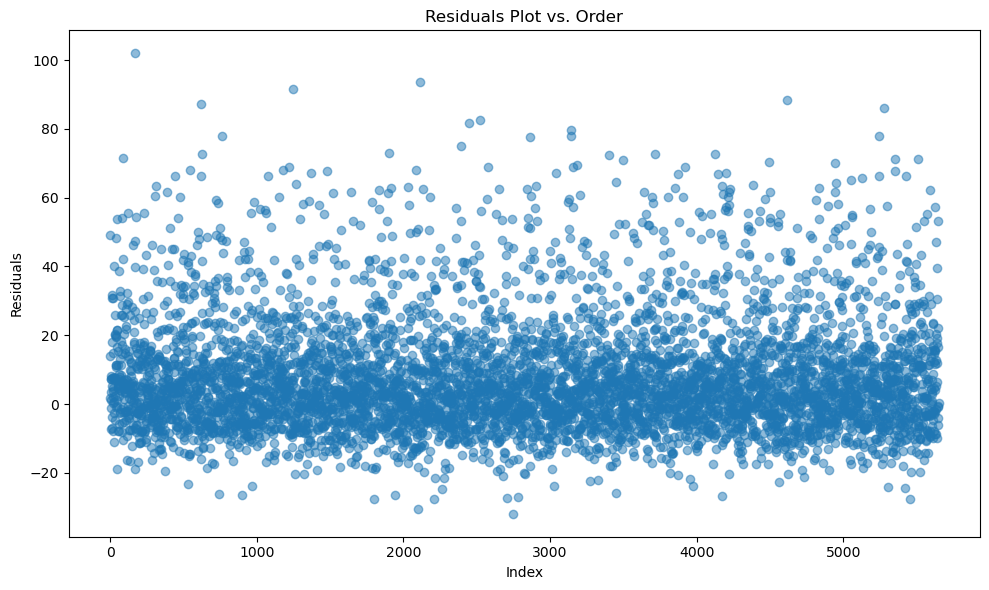

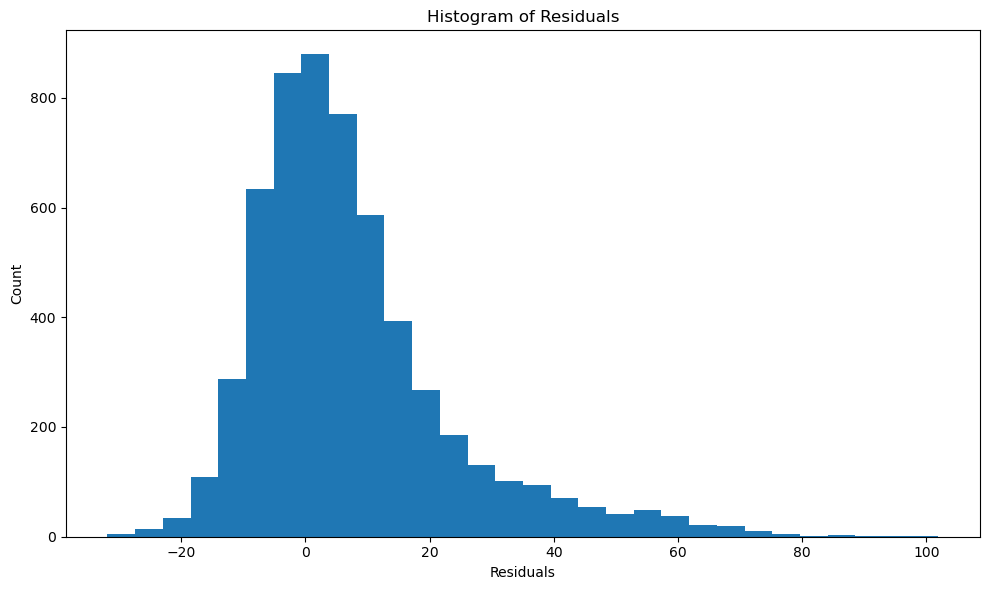

In [19]:

# Apply model to all data
X_full = pd.get_dummies(data, columns=['Gender'], drop_first=True)
X_full = X_full[['User_ID', 'Gender_male', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI']]
predicted_full = multi_linreg_predict(X_full, None, m)
ypreds_full = predicted_full['ypreds']
data['Predicted_Calories'] = ypreds_full

# Prepare unhealthy data for analysis
X_unhealthy, y_unhealthy = create_features(unhealthy)
X_unhealthy = X_unhealthy.astype(float)
y_unhealthy = y_unhealthy.astype(float)

# Apply model to unhealthy data
predicted_unhealthy = multi_linreg_predict(X_unhealthy, y_unhealthy, m)
res = predicted_unhealthy['resids']


plt.figure(figsize=(10, 6))
plt.scatter(range(len(X_unhealthy)), res, alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residuals Plot vs. Order")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(res, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


### Preliminary results:
#### Checking Assumptions 
* For residuals plot
  - There are more positive residuals that extend further from zero compared to negative residuals
  - These are some outliers above +80, which can mean the model underestimates the calories burned
* For residuals histogram
  - There is a positve skew (right-skewed) with an extension toward positive values up to 100
  - The positive skew indicates that the errors are not normally distributed, which could affect the p-values in our model
  - There is is a range from -30 to +100 with majority falling between -10 and +30 
* Normality of Residuals
  - Follows a somewhat normal distribution from -20 to 50
* Independence
  - The data is from different individuals based on their User_ID, which satisfied the independence assumption

#### Potential Improvements
* Maybe considering interactions between variables like age and duration
* Implementing a k-fold cross-validation can provide a better model performance

#### Ethical Considerations 
* Privacy and Data Protection
  - The dataset contains personal health information like a persons weight, height, and heart rate
  - Making sure the data is anonymized and secure is extremely critical
  - User_ID should not be traceable back to each individual
* Bias and Fairness
  - The BMI calculation and categorization may have cultural and racial biases
  - The model may perform differently for different demographic groups
* Potential for Misuse
  - Calorie prediction models could be misused in fitness apps or weight loss programs that promote unhealthy behaviors
  - Results could create pressure on individuals who are labeled as "Unhealthy" without considering their overall health context
* Accuracy and Harm
  - Inaccurate predictions could lead to inappropriate exercise or diet recommendations
  - The classification of "Healthy" vs. "Unhealthy" oversimplifies other complex health conditions
* Informed Consent
  - Its not clead if the individuals whose data is in the dataset provided informed consent
* Accessibility
  - Recommendations should account for individual limitations and capabilities